In [2]:
! git clone https://github.com/KulkarniKaustubh/CatDogClassification
! ls

Cloning into 'CatDogClassification'...
remote: Enumerating objects: 3025, done.
remote: Total 3025 (delta 0), reused 0 (delta 0), pack-reused 3025
Receiving objects: 100% (3025/3025), 65.91 MiB | 11.81 MiB/s, done.
Resolving deltas: 100% (3/3), done.
CatDogClassification  sample_data


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle
import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# all directories
TRAIN_DIR = 'CatDogClassification/extracted/cats_and_dogs_filtered/train'
VAL_DIR = 'CatDogClassification/extracted/cats_and_dogs_filtered/validation'
TRAIN_DIR_CATS = 'CatDogClassification/extracted/cats_and_dogs_filtered/train/cats'
TRAIN_DIR_DOGS = 'CatDogClassification/extracted/cats_and_dogs_filtered/train/dogs'
VAL_DIR_CATS = 'CatDogClassification/extracted/cats_and_dogs_filtered/validation/cats'
VAL_DIR_DOGS = 'CatDogClassification/extracted/cats_and_dogs_filtered/validation/dogs'

# getting images squared
imageSize = 200

# alpha
lr = 0.001

# momentum
beta_1 = 0.9

# mini-batch size
BATCH_SIZE = 32

# number of epochs
epochs = 50

# total training data and val data
totalTrain = len(os.listdir(TRAIN_DIR_CATS))
totalTrain += len(os.listdir(TRAIN_DIR_DOGS))

totalVal = len(os.listdir(VAL_DIR_CATS))
totalVal += len(os.listdir(VAL_DIR_DOGS))

In [89]:
# for data augmentation since we have a small training set
trainImageGenerator = ImageDataGenerator(
                                        rescale = 1./255.,  # normalization
                                        rotation_range = 40,  # range of rotation
                                        width_shift_range = 0.2,
                                        height_shift_range = 0.2,
                                        shear_range = 0.2,
                                        zoom_range = 0.2,
                                        horizontal_flip = True,  # fliiping images horizontally
                                        fill_mode = 'nearest'  # any pixel gaps will be filled with the 'nearest' pizel
                                        )

validationImageGenerator = ImageDataGenerator(
                                        rescale = 1./255.
                                        )

In [90]:
# declaring training data
trainingData = trainImageGenerator.flow_from_directory(
                                        batch_size = BATCH_SIZE,
                                        directory = TRAIN_DIR,
                                        shuffle = True,
                                        target_size = (imageSize, imageSize),
                                        class_mode = 'binary'   # only cats or dogs, binary classification
                                        )

validationData = validationImageGenerator.flow_from_directory(
                                        batch_size = BATCH_SIZE,
                                        directory = VAL_DIR,
                                        shuffle = False,
                                        target_size = (imageSize, imageSize),
                                        class_mode = 'binary'
                                        )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [91]:
# printing classes
print(trainingData.class_indices)

{'cats': 0, 'dogs': 1}


In [113]:
# clearing previous models
K.backend.clear_session()

# defining the model
model = K.models.Sequential([
    Conv2D(filters = 16, kernel_size = (3, 3), input_shape = (imageSize, imageSize, 3)), # 3 for RGB
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size = (2, 2)),
    
    Conv2D(filters = 32, kernel_size = (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size = (2, 2)),
    
    Conv2D(filters = 64, kernel_size = (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size = (2, 2)),
    
    Conv2D(filters = 128, kernel_size = (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size = (2, 2)),

    Conv2D(filters = 128, kernel_size = (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size = (2, 2)),
    
#     Conv2D(8, (1, 1)),
#     BatchNormalization(),
    
    Flatten(),
    
    Dense(units = 512,
          activation = 'relu',
          kernel_regularizer = K.regularizers.l1_l2(l1=1e-5, l2=1e-4),
          activity_regularizer = K.regularizers.l2(1e-5)
          ),
    BatchNormalization(),
    Dropout(rate = 0.5),        # regularization to reduce variance

    Dense(units = 512,
          activation = 'relu',
          kernel_regularizer = K.regularizers.l1_l2(l1=1e-5, l2=1e-4),
          activity_regularizer = K.regularizers.l2(1e-5)
          ),
    BatchNormalization(),
    Dropout(rate = 0.5),
    
    Dense(units = 2, activation = 'softmax')
    
], name = 'cats-vs-dogs')

In [117]:
# compiling the model
opt = K.optimizers.Adam(lr = lr, beta_1 = beta_1, beta_2 = 0.999, decay = 1e-6)
model.compile (
    optimizer = opt,
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
    )

In [118]:
# summary of the model
model.summary()

Model: "cats-vs-dogs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 198, 198, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 198, 198, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 97, 97, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 97, 97, 32)       

In [119]:
# fit is overloaded with fit_generator in TensorFlow 2.2+, hence, using fit
history = model.fit(
    trainingData,
    steps_per_epoch = totalTrain // BATCH_SIZE,  # steps per epoch is defined as total by batch size
    epochs = epochs,
    validation_data = validationData,
    validation_steps = totalVal // BATCH_SIZE
    )

Epoch 1/50
62/62 [==============================] - 29s 461ms/step - loss: 1.4335 - accuracy: 0.5457 - val_loss: 1.7646 - val_accuracy: 0.5040
Epoch 2/50
62/62 [==============================] - 28s 456ms/step - loss: 1.2894 - accuracy: 0.5691 - val_loss: 1.2483 - val_accuracy: 0.5040
Epoch 3/50
62/62 [==============================] - 28s 457ms/step - loss: 1.2206 - accuracy: 0.5803 - val_loss: 1.2564 - val_accuracy: 0.5040
Epoch 4/50
62/62 [==============================] - 28s 455ms/step - loss: 1.1219 - accuracy: 0.6052 - val_loss: 1.0677 - val_accuracy: 0.5817
Epoch 5/50
62/62 [==============================] - 28s 457ms/step - loss: 1.0726 - accuracy: 0.6418 - val_loss: 1.0762 - val_accuracy: 0.5403
Epoch 6/50
62/62 [==============================] - 28s 454ms/step - loss: 1.0509 - accuracy: 0.6535 - val_loss: 1.0312 - val_accuracy: 0.6139
Epoch 7/50
62/62 [==============================] - 28s 457ms/step - loss: 0.9995 - accuracy: 0.6773 - val_loss: 0.9381 - val_accuracy: 0.7077

<Figure size 432x288 with 0 Axes>

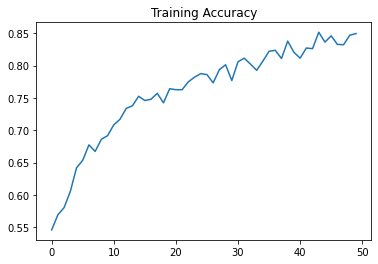

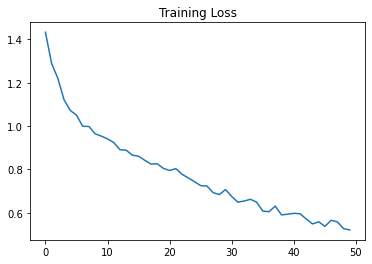

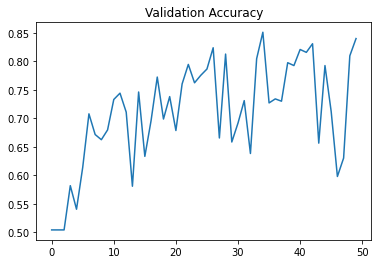

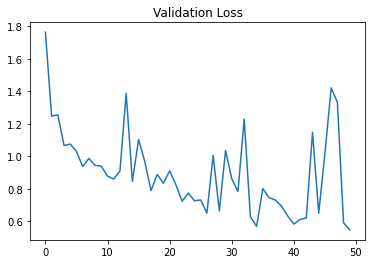

<Figure size 432x288 with 0 Axes>

In [120]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))

plt.plot(epochs, acc)
plt.title('Training Accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.title('Training Loss')
plt.figure()

valAcc = history.history['val_accuracy']
valLoss = history.history['val_loss']

plt.plot(epochs, valAcc)
plt.title('Validation Accuracy')
plt.figure()

plt.plot(epochs, valLoss)
plt.title('Validation Loss')
plt.figure()

In [121]:
model.evaluate(validationData, batch_size = BATCH_SIZE)

32/32 [==============================] - 4s 111ms/step - loss: 0.5516 - accuracy: 0.8390


[0.5515832304954529, 0.8389999866485596]

In [122]:
# saving json format of model
modelJSON = model.to_json()
with open('cats_vs_dogs-model-2-regularized.json', 'w') as file:
    file.write(modelJSON)
    
# saving weights of model
model.save_weights("cats_vs_dogs_weights-model-2-regularized.h5")

#printing confirmation
print("Saved model to disk")

Saved model to disk


In [ ]:
# loading model
jsonFile = open('cats_vs_dogs.json', 'r')
loadedJSONModel = jsonFile.read()
jsonFile.close()
loadedModel = K.models.model_from_json(loadedJSONModel)

# loading weights using this model
loadedModel.load_weights('cats_vs_dogs_weights.h5')

In [67]:
# compiling the loaded model
loadedModel.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

# evaluating the loaded model
loadedModel.evaluate(validationData, batch_size = BATCH_SIZE)

32/32 [==============================] - 4s 121ms/step - loss: 0.5833 - accuracy: 0.7310


[0.5832808613777161, 0.7310000061988831]